# Gathering data

In [1]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

We will download dog images using the Bing Search Image API. To get images from Bing, you will need to get a key from [Microsoft Azure](https://www.microsoft.com/en-us/bing/apis/bing-image-search-api) and replace `"XXX"` with your new key inside the method `search_images_bing`.

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [5]:
results = search_images_bing(key, 'winner dog')
ims = results.attrgot('content_url')
len(ims)

150

In [6]:
dog_types = 'Winner','Chihuahua','Basset Hound'
path = Path('dogs')

In [7]:
if not path.exists():
    path.mkdir()
    for o in dog_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dog')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns

(#433) [Path('dogs/Winner/00000011.jpg'),Path('dogs/Winner/00000008.jpg'),Path('dogs/Winner/00000009.jpg'),Path('dogs/Winner/00000050.jpg'),Path('dogs/Winner/00000135.jpg'),Path('dogs/Winner/00000074.jpg'),Path('dogs/Winner/00000033.jpg'),Path('dogs/Winner/00000097.jpg'),Path('dogs/Winner/00000025.png'),Path('dogs/Winner/00000070.jpg')...]

# Clean data

In [9]:
failed = verify_images(fns)
failed

(#0) []

In [10]:
failed.map(Path.unlink);

# Dataloader

In [15]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = dogs.dataloaders(path)

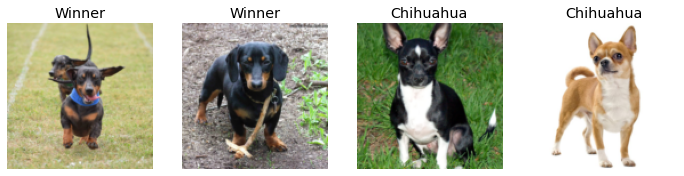

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

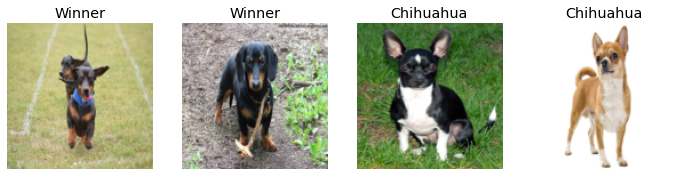

In [13]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

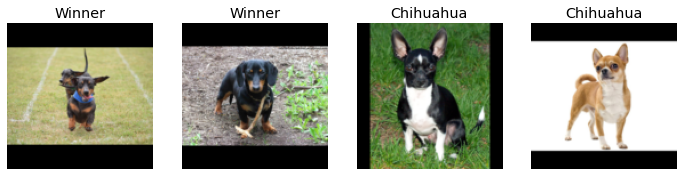

In [14]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

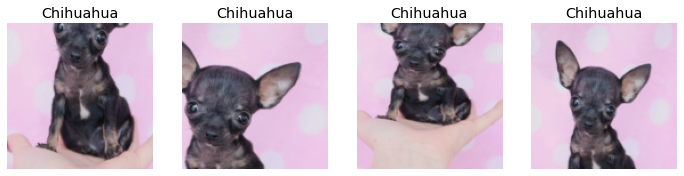

In [20]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

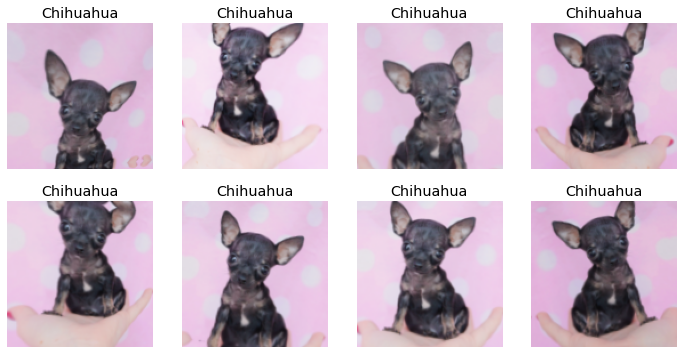

In [19]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [24]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

# Training Your Model, and Using It to Clean Your Data

In [25]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.552237,0.135857,0.046512,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.262435,0.044997,0.023256,00:26
1,0.192472,0.010677,0.000000,00:31
2,0.142622,0.005792,0.000000,00:24
3,0.109661,0.004029,0.000000,00:26


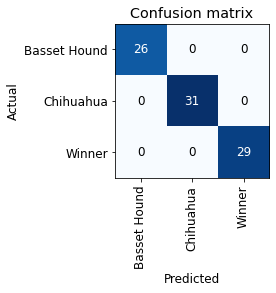

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

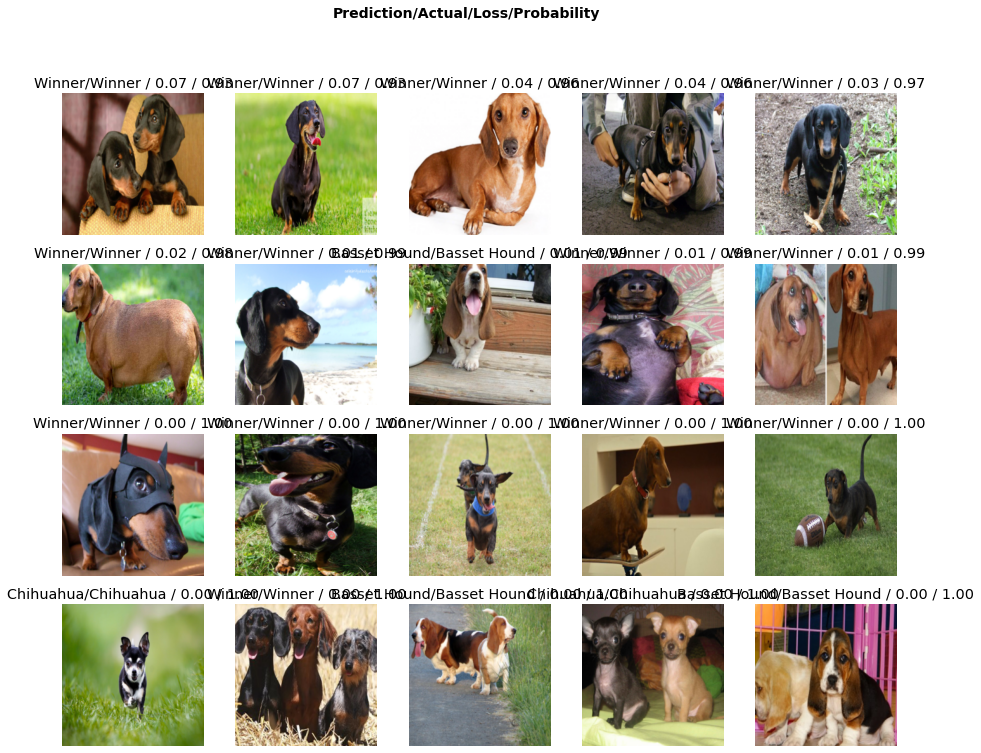

In [33]:
interp.plot_top_losses(20, nrows=4)

In [ ]:
cleaner = ImageClassifierCleaner(learn, max_n=150)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Save model

In [23]:
learn.export('dog.pkl')

In [24]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('dog.pkl')]

In [14]:
learn = load_learner('dog.pkl')